### MEC2015 - System Identification

#### Student: Felipe da Costa Pereira



___

#### Activity Number 02 - Model validation

Using the robot arm data and the models from last activity:
- Finish your code for FR predictions (if there is anything left from last week)      
- Identify the same models with the orders you have performed in the last activity and provide (split the dataset into estimation and test, e.g. 50/50%)      
    
    - A table with R2 or MSE for OSA and FR (you should have this ready from last week)      
    
    - The statistical tests based on correlation (for linear models) using the OSA error (include in the report only the plots for the best FR)      
    
    - Try to analyse the outcome of the statistical tests and the R2 in OSA and FR. Can this model stil be improved using the same dataset?      




Exemple code

In [1]:
% MEC 2015 System identification
% Prof Helon Ayala

% 01_MQB

pkg load control;
clc
clear
close all
rng(1) % permite reproducibilidade

___
Implementing `matreg` function

In [2]:
function [Phi,yTARG] = matreg(y,u,na,nb)
    N = length(y);
    p = 1 + max(na,nb);
    Phi = [];

    if N<p  % tratando exceção do caso de N<p, caso da inicialização da simulação livre.
        Phi = [Phi; -y'(p-1:-1:p-na) u'(p-1:-1:p-nb)];
        yTARG = y(N);
    else
        for index = 0:N-p
            Phi = [Phi; -y'(p-1+index:-1:p-na+index) u'(p-1+index:-1:p-nb+index)];
        end
        yTARG = y(p:N);
    end
end

%%%%%%%%%%%%%%%%%%%%%%%%%%%% TESTE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% m=6;
% y_ = YTRA(1:m)'
% [Phi,yTARG] = matreg(YTRA(1:m),UTRA(1:m), 2, 2);
% Phi
% yTARG
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Implementing the `Free Simulation` function

In [3]:
function yhat_FS = freeSim(y,u,na,nb,th)
    p = 1 + max(na,nb);
    N = length(y);
    yhat_FS = [];
    
    y_temp = y(1:p-1);
    u_temp = u(1:p-1);
    [Phi_k, ~] = matreg(y_temp, u_temp, na, nb);
    yhat_k = Phi_k(end,:) * th;
    
    % shift circular no y_temp, u_temp (remove o da esq e add no da direita)
    y_temp = [y_temp(2:end);yhat_k];
   
    % start predictions
    for k=p:N
        u_temp = [u_temp(2:end);u(k)];    
        [Phi_k, ~] = matreg(y_temp, u_temp, na, nb);
        yhat_k = Phi_k(end,:) * th;
        y_temp = [y_temp(2:end);yhat_k];
        
        % store predictions
        yhat_FS = [yhat_FS;yhat_k];
    end
end

%%%%%%%%%%%%%%%%%%%%%%%%%%%% TESTE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% m=10;
% y_ = YTRA(1:m)'
% u_ = UTRA(1:m)'
% y_pred = freeSim(YTRA(1:m),UTRA(1:m), na, nb, th_hat);
% % plot(y_pred)
% length(y_pred)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#### Real case application: robot flexible arm

___
#### Linear System Identification through Batch Least Squares

Exercise:  

Now it’s time to practice. You will identify an ARX model for a mechanical system which you assume not to know the structure.
- Go to: http://homes.esat.kuleuven.be/~smc/daisy/daisydata.html and download the “Data from a flexible robot arm”
- Read the description of the system
- Take some time to read about other benchmark case studies on the DAISy website, maybe you find something interesting for your final project 
- Read the data in MATLAB and inspect it
- Perform the following (deliver a PDF file with the results and code)
    1. Perform the identification for a number of combinations of na, nb
    2. Plot the following graphs (for estimation and validation) for all combinations of na, nb  
        - Model predictions and measured outputs  
        - Model residuals  
    3. Analyze for this dataset which could be a parsimonious model order

https://homes.esat.kuleuven.be/~smc/daisy/daisydata.html

> Description:  
	- Data from a flexible robot arm. The arm is installed on an electrical motor. We have modeled the transfer function from the measured reaction torque of the structure on the ground to the acceleration of the flexible arm.  The applied input is a periodic sine sweep.    
	
> Columns:    
	- Column 1: input u: reaction torque of the structure   
	- Column 2: output y: accelaration of the flexible arm

Inspecting $u$ and $y$

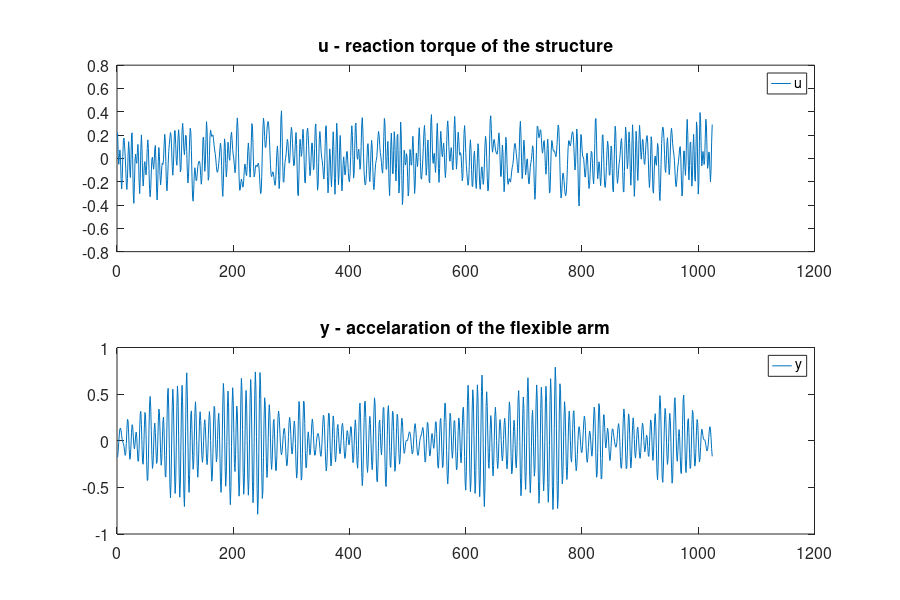

In [4]:
set(gcf, 'Position', [0 0 900 600]);
data = load('./robot_arm.dat/robot_arm.dat', '-ascii');

U = data(:,1);
Y = data(:,2);

subplot (211), plot(U), title('u - reaction torque of the structure'), legend('u');
subplot (212), plot(Y), title('y - accelaration of the flexible arm'), legend('y');

Splitting $u$ and $y$ into work (estimation) and validation data

In [5]:
UTRA=U(1:512);
UVAL=U(513:end);
YTRA=Y(1:512);
YVAL=Y(513:end);

Perform the identification for a number of combinations of na, nb

In [6]:
order_range = [2:4 6:17]

order_range =

    2    3    4    6    7    8    9   10   11   12   13   14   15   16   17



Performing Identification, plotting measured and predicted values of $y$, storing the $R^2$ score for further comparison

In [7]:
R2_TRA_OSA = [];
R2_TRA_FR = [];
R2_VAL_OSA = [];
R2_VAL_FR = [];

for n = order_range
    na=n;
    nb=n;

    % construct regression matrix (using the matreg function)
    [Phi, Y1] = matreg(YTRA, UTRA, na, nb);
    [PhiVAL, Y2] = matreg(YVAL, UVAL, na, nb);

    % estimate parameters:
    th_hat = (Phi'*Phi)^(-1)*Phi'*Y1; % batch least squares

    % one step ahead prediction
    yhat_TRA_OSA = Phi*th_hat;
    yhat_VAL_OSA = PhiVAL*th_hat;
    
    % free run simulation 
    yhat_TRA_FR = freeSim(YTRA,UTRA,na,nb,th_hat);
    yhat_VAL_FR = freeSim(YVAL,UVAL,na,nb,th_hat);

    % Calulando R2
    R2_TRA_OSA = [R2_TRA_OSA; mult_corr(Y1, yhat_TRA_OSA)];
    R2_VAL_OSA = [R2_VAL_OSA; mult_corr(Y2, yhat_VAL_OSA)];
    R2_TRA_FR = [R2_TRA_FR; mult_corr(Y1, yhat_TRA_FR)];
    R2_VAL_FR = [R2_VAL_FR; mult_corr(Y2, yhat_VAL_FR)];
end

In [8]:
fprintf('R2 obtained (1 is perfect) \n')
fprintf('Order \t R2_TRA_OSA \t R2_VAL_OSA \t R2_TRA_FR \t R2_VAL_FR\n')
for n = 1:length(order_range)
    % fprintf('%2d \t %0.3f \t\t %0.3f\n', n, R2_VAL_OSA(n-1), R2_VAL_FR(n-1))
    fprintf('%d \t %0.4f \t %0.4f \t %0.4f \t %0.4f\n',order_range(n),R2_TRA_OSA(n),R2_VAL_OSA(n),R2_TRA_FR(n),R2_VAL_FR(n))
end

R2 obtained (1 is perfect) 
Order 	 R2_TRA_OSA 	 R2_VAL_OSA 	 R2_TRA_FR 	 R2_VAL_FR
2 	 0.9916 	 0.9910 	 0.3120 	 0.3100
3 	 0.9978 	 0.9977 	 0.4536 	 0.4415
4 	 0.9997 	 0.9996 	 -0.0769 	 -0.1461
6 	 1.0000 	 1.0000 	 0.4733 	 0.4549
7 	 1.0000 	 1.0000 	 0.4799 	 0.4611
8 	 1.0000 	 1.0000 	 0.4478 	 0.4292
9 	 1.0000 	 1.0000 	 0.4486 	 0.4318
10 	 1.0000 	 1.0000 	 0.4406 	 0.4224
11 	 1.0000 	 1.0000 	 0.4422 	 0.4241
12 	 1.0000 	 1.0000 	 0.4492 	 0.4317
13 	 1.0000 	 1.0000 	 0.4239 	 0.4065
14 	 1.0000 	 1.0000 	 0.4326 	 0.4117
15 	 1.0000 	 1.0000 	 0.4835 	 0.4660
16 	 1.0000 	 1.0000 	 0.2298 	 0.2055
17 	 1.0000 	 1.0000 	 0.4163 	 0.3949


#### Comments on the results:   

> - With $n_{a}=n_{b}=5$, the model gets unstable and the R2 gets worse, this model was omitted from the previsous table
> - Orders $n=6$, $n=7$ and $n=15$ had similar R2 scores, Let's choose order $n=15$ to the next steps (correlation plots)

Choosing models of order $n_{a}=n_{b}=4$ (worst, as a reference) and $n_{a}=n_{b}=15$ (best free run simulation) to plot their correlation tests

In [15]:
n_ref = 4;
n_best = 15;

% construct regression matrix (using the matreg function)
[Phi_ref, Y1_ref] = matreg(YTRA, UTRA, n_ref, n_ref);
[Phi, Y1] = matreg(YTRA, UTRA, n_best, n_best);
% [PhiVAL, Y2] = matreg(YVAL, UVAL, na, nb);

% estimate parameters:
th_hat_ref = (Phi_ref'*Phi_ref)^(-1)*Phi_ref'*Y1_ref; % batch least squares
th_hat = (Phi'*Phi)^(-1)*Phi'*Y1; % batch least squares

% one step ahead prediction
yhat_TRA_OSA_ref = Phi_ref*th_hat_ref;
yhat_TRA_OSA = Phi*th_hat;

Plotting correlation tests for the reference model

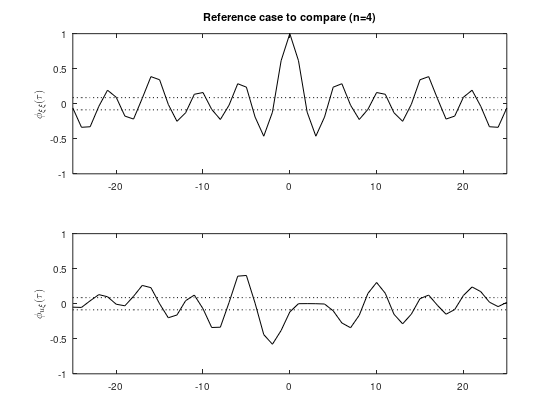

In [16]:
%% correlation based tests
plot_xcorrel_linear(Y1_ref-yhat_TRA_OSA_ref, UTRA(n_ref+1:end), 'Reference case to compare (n=4)');


Plotting correlation tests for the best free run simulation model

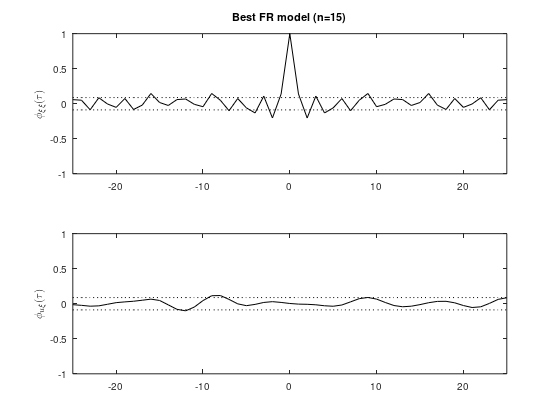

In [17]:
plot_xcorrel_linear(Y1-yhat_TRA_OSA,UTRA(n_best+1:end), 'Best FR model (n=15)')

#### Comments on the results:   

> - For the worst Free Run simulation Model ($n_{a}=n_{b}=4$), both the autocorrelation function $\varphi_{\xi\xi}(\tau)$ coefficients and the residuals-input cross-correlation function $\varphi_{u\xi}(\tau)$ coefficients present values that are exceeding the confidence intervals for several values of lags ($\tau$)
> 
> - Although the Free Run Simulation for the model order $n=15$ gives a poor $R^2$ score (0.4835), we can infer by the autocorrelation and cross-correlation plots that no big improvements could be done in the models using the selected dataset, as the values of these statistical tests coefficients are almost all inside the confidence band provided by those statistical tests.
>   